<a href="https://colab.research.google.com/github/YanSym/Data-Science-Projects/blob/master/IMDB_Analise_Sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP: Natural Language Processing
### Analise de sentimentos
### Disciplina: PCS5029

<img src="https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy" width=600 height=350/>

### Imports

In [47]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
import tensorflow_hub as hub
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, SpatialDropout1D
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from google.colab import drive
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from collections import Counter
import random

#!pip install transformers
#!pip install ktrain

import ktrain
from ktrain import text
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

#import kerastuner as kt
#from kerastuner.tuners import BayesianOptimization
#nltk.download('stopwords');

### Métodos

In [2]:
TAG_RE = re.compile(r'<[^>]+>')
list_stop_words = set(stopwords.words('english'))


def print_results(true, pred):
  # accuracy
  accuracy = accuracy_score(true, pred)
  accuracy = round(accuracy, 4)
  print ('Accuracy:', accuracy)

  # f1 score
  f1_score = metrics.f1_score(true, pred)
  f1_score = round(f1_score, 4)
  print ('F1 Score:', f1_score)
    
# plot resultados
def plot_results(history):
    # acuracia
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


# pre-processamento
def preprocess_text(sen):
    
    # Removing html tags
    sentence = TAG_RE.sub('', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lowercase
    sentence = sentence.lower()
    
    # remove stopwords
    #sentence = [w for w in sentence if w not in list_stop_words]

    return sentence

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Dataset

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

df_train = pd.DataFrame({'review':train_examples, 'sentiment':train_labels})
df_test = pd.DataFrame({'review':test_examples, 'sentiment':test_labels})

movie_reviews = pd.concat([df_train, df_test]).reset_index(drop=True)

movie_reviews['review'] = movie_reviews['review'].str.decode("utf-8")

print (movie_reviews.isnull().values.any())
print (movie_reviews.shape)

# amostra
movie_reviews, _ = train_test_split(movie_reviews, train_size=0.1, random_state=42, stratify=movie_reviews['sentiment'])
print (movie_reviews.shape)
movie_reviews.head()

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imdb_reviews/plain_text/1.0.0
INFO:absl:Load dataset info from /tmp/tmpfxvn1pwbtfds
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

INFO:absl:Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into /root/tensorflow_datasets/downloads/ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.5fc540a1bc2842a29c0ead3e44eb3f01...
INFO:absl:Generating split train


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4VXKFM/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4VXKFM/imdb_reviews-train.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4VXKFM/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4VXKFM/imdb_reviews-test.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split unsupervised


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4VXKFM/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete4VXKFM/imdb_reviews-unsupervised.tfrecord. Shard lengths: [50000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
False
(50000, 2)
(5000, 2)


,review,sentiment
41986,I was expecting a lot from Mr.Amitabh Bachan's...,0
33935,"Well, it has to be said that Monster Man is a ...",1
46975,Even though I have great interest in Biblical ...,0
16402,The world is made up two different types of mo...,1
39790,Background info - The movies Octopussy & Never...,1


### Analises

1    2500
0    2500
Name: sentiment, dtype: int64


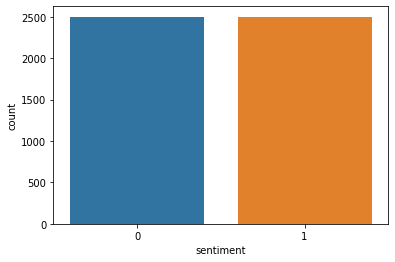

In [5]:
print (movie_reviews['sentiment'].value_counts(dropna=False))
sns.countplot(x='sentiment', data=movie_reviews)

In [6]:
movie_reviews['len'] = [len(sent) for sent in movie_reviews['review']]
print ('Max len:', movie_reviews['len'].max())
print ('Min len:', movie_reviews['len'].min())
print ('Mean len:', movie_reviews['len'].mean())

Max len: 12930
Min len: 111
Mean len: 1327.1528


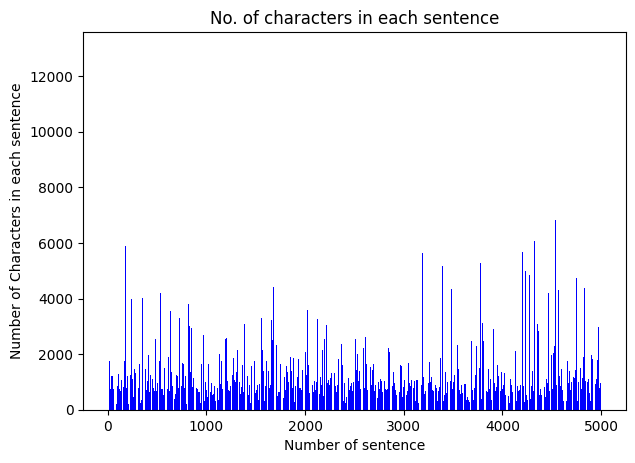

In [7]:
sentences = [len(sent) for sent in movie_reviews['review']]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(sentences)+1), sentences, color = ['blue'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

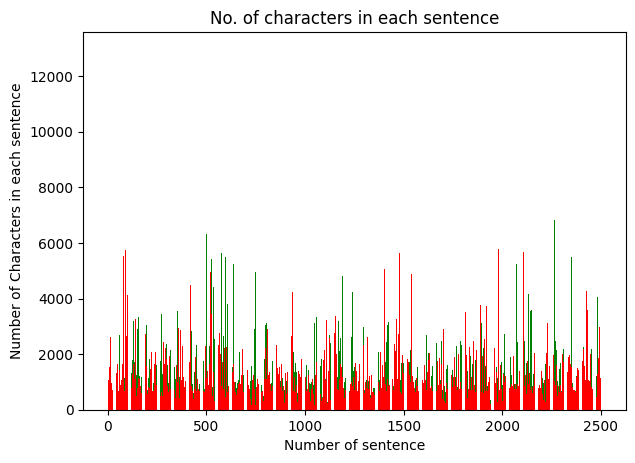

In [8]:
df_positive = movie_reviews.query('sentiment == 1')
df_negative = movie_reviews.query('sentiment == 0')

positive_sentences = [len(sent) for sent in df_positive['review']]
negative_sentences = [len(sent) for sent in df_negative['review']]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(positive_sentences)+1), positive_sentences, color = ['green'])
plt.bar(range(1, len(negative_sentences)+1), negative_sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence',
              xlabel='Number of sentence',
              ylabel='Number of Characters in each sentence');

In [9]:
movie_reviews['len'] = [len(sent) for sent in movie_reviews['review']]
movie_reviews_short = movie_reviews.query("len <= 200")
movie_reviews_lon = movie_reviews.query("len >= 3_000")

print(movie_reviews['sentiment'].value_counts(dropna=False, normalize=True))
print(movie_reviews_short['sentiment'].value_counts(dropna=False, normalize=True))
print(movie_reviews_lon['sentiment'].value_counts(dropna=False, normalize=True))

1    0.5
0    0.5
Name: sentiment, dtype: float64
1    0.5
0    0.5
Name: sentiment, dtype: float64
1    0.552
0    0.448
Name: sentiment, dtype: float64


### Palavras mais frequentes nas críticas

In [10]:
lista_strings = ' '.join(df_positive['review'].tolist()).split(' ')
counter_object = Counter(lista_strings)
palavras_mais_aparecem_positivos = [valor[0] for valor in counter_object.most_common(1000)]

lista_strings = ' '.join(df_negative['review'].tolist()).split(' ')
counter_object = Counter(lista_strings)
palavras_mais_aparecem_negativos = [valor[0] for valor in counter_object.most_common(1000)]

lista_positivos = list(set(palavras_mais_aparecem_positivos).difference(set(palavras_mais_aparecem_negativos)))
print ('Positivas:')
print (lista_positivos)

lista_negativos = list(set(palavras_mais_aparecem_negativos).difference(set(palavras_mais_aparecem_positivos)))
print ('Negativas:')
print (lista_negativos)

print ('Palavras positivas:')
list_positive_words = ['like', 'love', 'good', 'amazing', 'pure', 'lovely', 'best', 'enjoyable', 'talanted', 'fantastic', 'best', 'superb', 'incredible', 'happy']
print (list_positive_words)

print ('Palavras positivas:')
list_negative_words = ['wasted', 'disappointed', 'horrible', 'fake', 'killing', 'awful', 'pathetic', 'screenplay', 'joke', 'ridiculous', 'boring', 'bad', 'silly']
print (list_negative_words)

Positivas:
['William', 'today', 'funniest', 'changes', 'her,', 'portrayal', 'favorite', 'watch.', 'dark', 'uses', 'portrayed', 'elements', 'actors,', '/>A', "'The", 'incredible', "He's", 'fantastic', 'tale', 'level', 'amazing', 'political', 'romantic', 'Disney', 'soundtrack', 'Oscar', 'animation', 'reality', 'worked', 'various', 'episodes', 'atmosphere', 'murder', 'recent', "/>It's", 'York', 'forget', 'great,', 'novel', "who's", 'admit', 'question', 'emotions', 'follows', 'sometimes', 'telling', 'enjoyable', 'dance', 'brilliant', 'modern', 'brings', 'catch', 'French', 'Japanese', 'crime', 'public', 'documentary', 'easy', 'talented', 'Steve', 'control', 'parents', 'towards', 'Paul', 'Peter', 'Ben', 'intelligent', 'Jane', 'Dr.', 'War', 'compared', 'forward', 'boys', 'pure', 'musical', 'greatest', 'message', 'among', 'emotional', 'directors', 'years.', 'OF', 'King', 'highly', 'it!', 'ways', 'supporting', 'release', 'overall', 'roles', 'whom', 'heart', 'ones', 'moving', 'miss', 'future', '

### Pre-processamento

In [11]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']

### Separa dados em treino e teste

In [12]:
# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val_tmp, X_test_tmp, y_val_tmp, y_test_tmp = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

### Modelo Dummy

In [13]:
list_positive_words = ['like', 'love', 'good', 'amazing', 'pure', 'lovely', 'best', 'enjoyable', 'talanted', 'fantastic', 'best', 'superb', 'incredible', 'happy']
list_negative_words = ['wasted', 'disappointed', 'horrible', 'fake', 'killing', 'awful', 'pathetic', 'screenplay', 'joke', 'ridiculous', 'boring', 'bad', 'silly']

def modelo_dummy(texto):
  texto = texto.split(' ')
  if any(x in list_positive_words for x in texto):
    return 1
  elif any(x in list_negative_words for x in texto):
    return 0
  else:
    return random.randint(0, 1)

df_train = pd.DataFrame(X_train, columns=['review'])
df_test = pd.DataFrame(X_test, columns=['review'])

df_train['prediction_dummy'] = df_train['review'].apply(modelo_dummy)
df_test['prediction_dummy'] = df_test['review'].apply(modelo_dummy)

score_train = round(accuracy_score(df_train['prediction_dummy'], y_train), 4)
score_test = round(accuracy_score(df_test['prediction_dummy'], y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, df_test['prediction_dummy'])

Train Accuracy: 0.5402
Test Accuracy: 0.535
Accuracy: 0.535
F1 Score: 0.6588


### Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val_tmp = tokenizer.texts_to_sequences(X_val_tmp)
X_test_tmp = tokenizer.texts_to_sequences(X_test_tmp)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val_tmp = pad_sequences(X_val_tmp, padding='post', maxlen=maxlen)
X_test_tmp = pad_sequences(X_test_tmp, padding='post', maxlen=maxlen)

## Modelos com Bag of Words

### Bag of Words

<img src="https://i.ibb.co/j5Dj80T/bad.png" width=400 height=200/>

In [15]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### BoW (Bag of Words) + Logistic Regression

In [16]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.9988
Test Accuracy: 0.799
Accuracy: 0.799
F1 Score: 0.7972


### Score test

In [17]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)   
        instance = ' '.join([str(x) for x in instance])
        
        #transform test
        instance = CountVec.transform([instance])

        #create dataframe
        instance=pd.DataFrame(instance.toarray(), columns=CountVec.get_feature_names())

        score = classifier.predict_proba(instance)[:, 1][0]
        print (score)
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']
# score list
score_list(list_instances)

0.9393853698669685
0.09259102304322094


,text,score,rating
0,"The movie was amazing, I loved it, very good",0.939385,Positivo
1,"I hate this movie, it is very bad and terrible",0.092591,Negativo


### BoW (Bag of Words) + Naive Bayes

In [18]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.8908
Test Accuracy: 0.688
Accuracy: 0.688
F1 Score: 0.6797


### BoW (Bag of Words) + Random Forest

In [19]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.8298
Test Accuracy: 0.772
Accuracy: 0.772
F1 Score: 0.7869


## Modelos com tf-idf

<img src="https://miro.medium.com/max/1000/1*KZrjbKHcsWt-zzUj2oRk3w.jpeg" width=400 height=200/>

<img src="https://i.ytimg.com/vi/vZAXpvHhQow/maxresdefault.jpg" width=600 height=290/>

In [20]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
vectorizer = TfidfVectorizer()

#transform train
Count_data_train = vectorizer.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = vectorizer.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### Tf-Idf (Bag of Words) + Logistic Regression

In [21]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.9205
Test Accuracy: 0.823
Accuracy: 0.823
F1 Score: 0.8232


### Tf-Idf (Bag of Words) + Naive Bayes

In [22]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.9072
Test Accuracy: 0.679
Accuracy: 0.679
F1 Score: 0.6748


### Tf-Idf (Bag of Words) + Decision Tree

In [23]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.676
Test Accuracy: 0.633
Accuracy: 0.633
F1 Score: 0.7019


### Tf-Idf (Bag of Words) + Random Forest (max_depth=3)

In [24]:
classifier = RandomForestClassifier(max_depth=3)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.809
Test Accuracy: 0.732
Accuracy: 0.732
F1 Score: 0.75


### Tf-Idf (Bag of Words) + Random Forest (max_depth=5)

In [25]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.839
Test Accuracy: 0.768
Accuracy: 0.768
F1 Score: 0.7815


### Tf-Idf (Bag of Words) + Random Forest (max_depth=7)

In [26]:
classifier = RandomForestClassifier(max_depth=7)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.859
Test Accuracy: 0.745
Accuracy: 0.745
F1 Score: 0.7588


### Tf-Idf (Bag of Words) + Random Forest (max_depth=15)

In [27]:
classifier = RandomForestClassifier(max_depth=15)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.9458
Test Accuracy: 0.771
Accuracy: 0.771
F1 Score: 0.7779


## Modelos com Embedding

### Regressão Logística

In [28]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.5638
Test Accuracy: 0.53
Accuracy: 0.53
F1 Score: 0.5446


### Naive Bayes

In [29]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.563
Test Accuracy: 0.523
Accuracy: 0.523
F1 Score: 0.4832


### Árvore de Decisão

In [30]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.5868
Test Accuracy: 0.514
Accuracy: 0.514
F1 Score: 0.3639


### Random Forest

In [31]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.8148
Test Accuracy: 0.541
Accuracy: 0.541
F1 Score: 0.4917


### Modelo simples com Redes Neurais v1 (sem Early Stopping)

In [32]:
def predict_class(lista):
  lista_return = []
  for element in lista:
    lista_return.append(int(element>=0.5))
  return lista_return

Epoch 1/50
25/25 [==============================] - 4s 12ms/step - loss: 286.3722 - acc: 0.5041 - val_loss: 146.7019 - val_acc: 0.4825
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 157.9570 - acc: 0.5225 - val_loss: 93.7434 - val_acc: 0.4875
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 104.9094 - acc: 0.5063 - val_loss: 60.8773 - val_acc: 0.4850
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 66.2217 - acc: 0.5263 - val_loss: 40.1467 - val_acc: 0.5113
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 52.6622 - acc: 0.5034 - val_loss: 28.2673 - val_acc: 0.4988
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 38.8877 - acc: 0.4950 - val_loss: 19.3588 - val_acc: 0.4975
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 27.4243 - acc: 0.5134 - val_loss: 14.0455 - val_acc: 0.5025
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss:

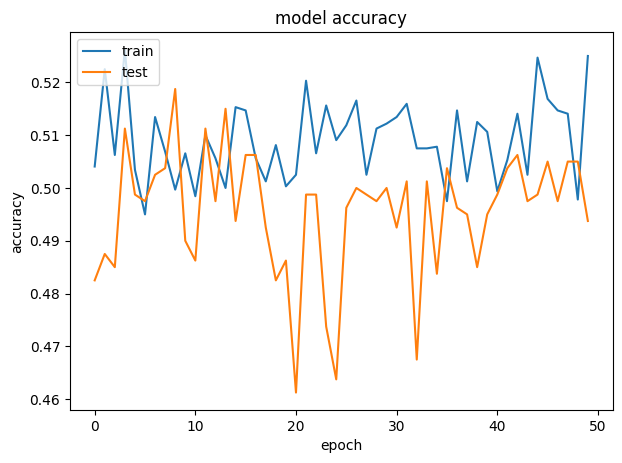

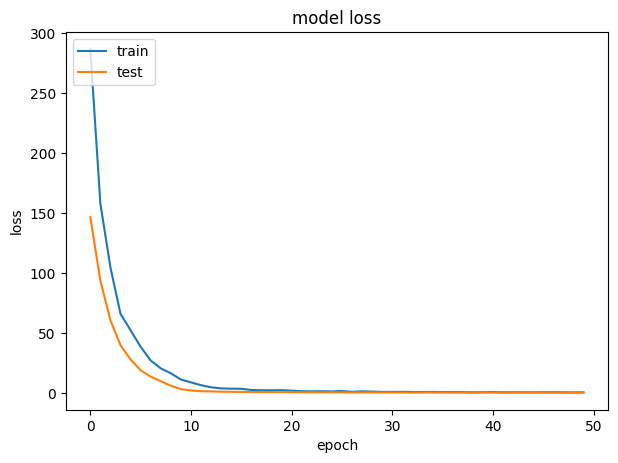

In [33]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Modelo simples com Redes Neurais  (Early Stopping)

Epoch 1/30
32/32 [==============================] - 1s 9ms/step - loss: 73.2347 - acc: 0.5040 - val_loss: 12.4465 - val_acc: 0.5175

Epoch 00001: val_loss improved from inf to 12.44646, saving model to best_model.h5
Epoch 2/30
32/32 [==============================] - 0s 4ms/step - loss: 3.1116 - acc: 0.5058 - val_loss: 2.5897 - val_acc: 0.5175

Epoch 00002: val_loss improved from 12.44646 to 2.58969, saving model to best_model.h5
Epoch 3/30
32/32 [==============================] - 0s 4ms/step - loss: 1.0143 - acc: 0.5050 - val_loss: 2.0359 - val_acc: 0.5188

Epoch 00003: val_loss improved from 2.58969 to 2.03585, saving model to best_model.h5
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.8798 - acc: 0.5042 - val_loss: 1.9550 - val_acc: 0.5188

Epoch 00004: val_loss improved from 2.03585 to 1.95496, saving model to best_model.h5
Epoch 5/30
32/32 [==============================] - 0s 4ms/step - loss: 0.8090 - acc: 0.5045 - val_loss: 1.8075 - val_acc: 0.5188

E

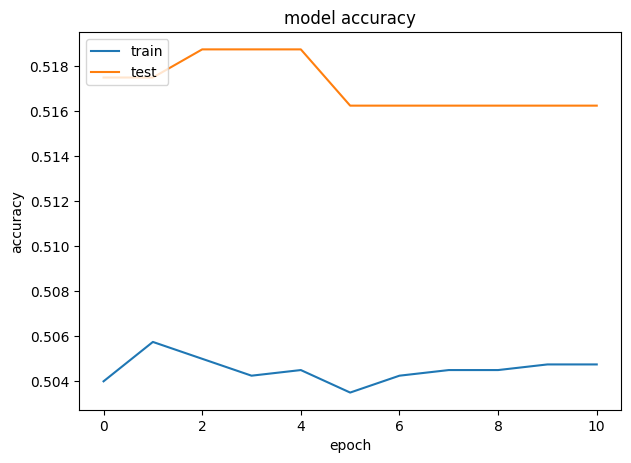

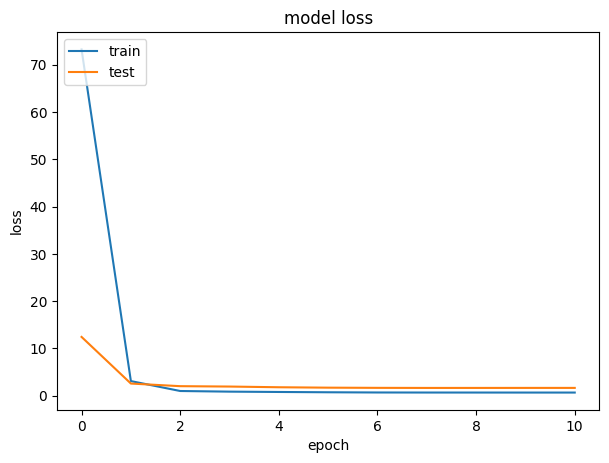

In [34]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val_tmp, y_val_tmp), batch_size=128, epochs=30, verbose=1, callbacks=[es, mc])
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Simple Model Embedding layer (sem Glove)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3516900   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 3,526,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 16ms/step - loss: 0.6912 - acc: 0.5328 - val_loss: 0.6878 - val_acc: 0.5675

Epoch 00001: val_loss improved from inf to 0.68782, saving model to best_model.h5
Epoch 2/20
25/25 [==============================] - 0s 8ms/step - loss: 0.6329 - acc: 0.9000 - val_loss: 0.6722 - val_acc: 0.6325

Epoch 00002: val_loss im

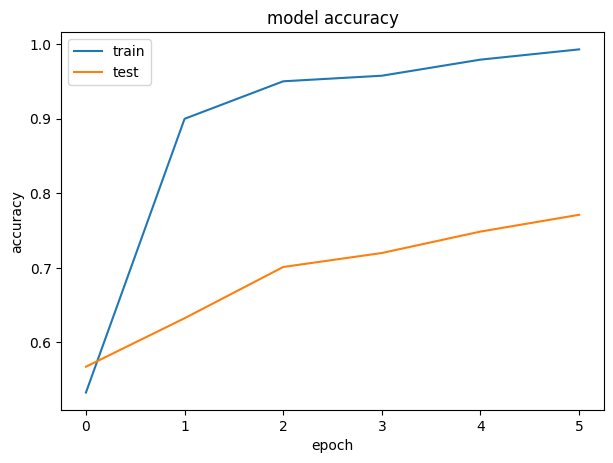

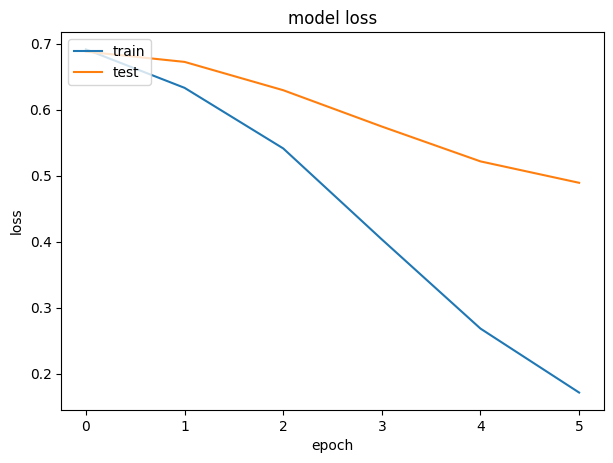

In [35]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Glove

In [36]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Simple Model Glove (sem Early Stopping)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 10ms/step - loss: 0.7022 - acc: 0.5572 - val_loss: 0.6758 - val_acc: 0.5987
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 0.5405 - acc: 0.7391 - val_loss: 0.6658 - val_acc: 0.6100
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4576 - acc: 0.8141 - val_loss

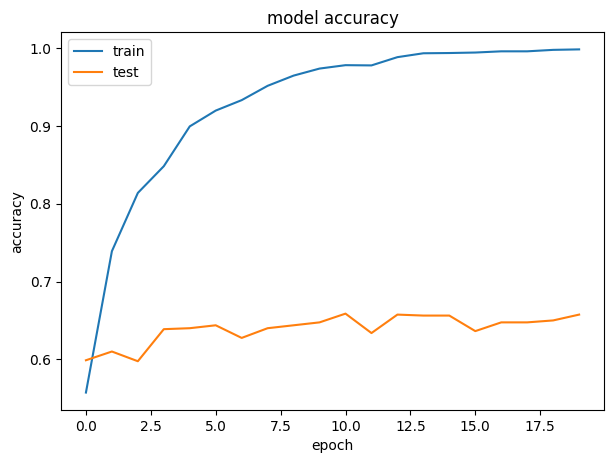

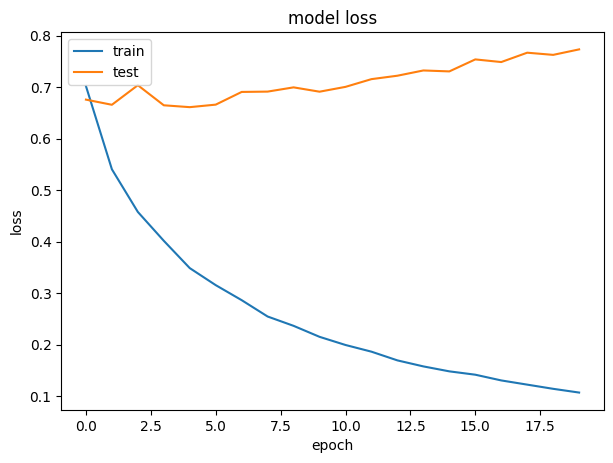

In [37]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Simple Model Glove (com Early Stopping)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 1s 10ms/step - loss: 0.6910 - acc: 0.5750 - val_loss: 0.6842 - val_acc: 0.5713

Epoch 00001: val_loss improved from inf to 0.68416, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: 0.5325 - acc: 0.7559 - val_loss: 0.6643 - val_acc: 0.6175

Epoch 00002: val_lo

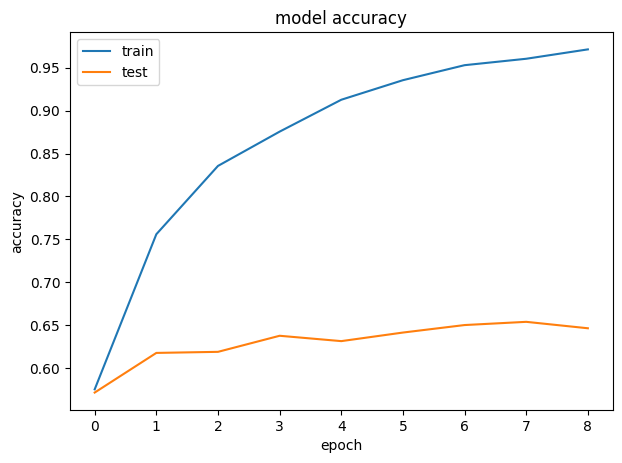

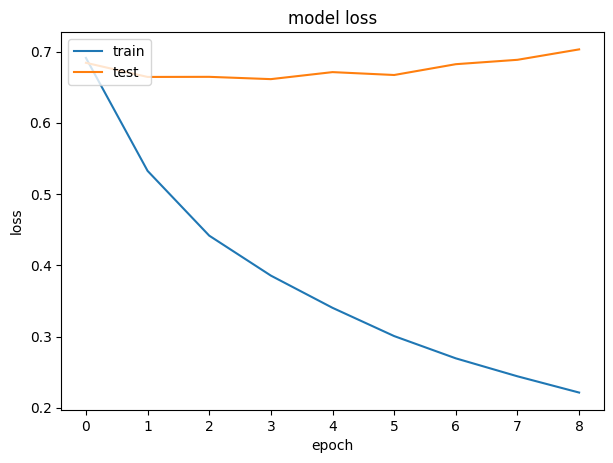

In [38]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### CNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 3,581,157
Trainable params: 64,257
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/50
25/25 [==============================] - 26s 20ms/step - loss: 0.6571 - acc: 0.6209 - val_loss: 0.6355 - val_acc: 0.6313
Epoch 2/50
25/25 [==============================] - 0s 11ms/step - loss: 0.5276 - acc: 0.7769 - val_

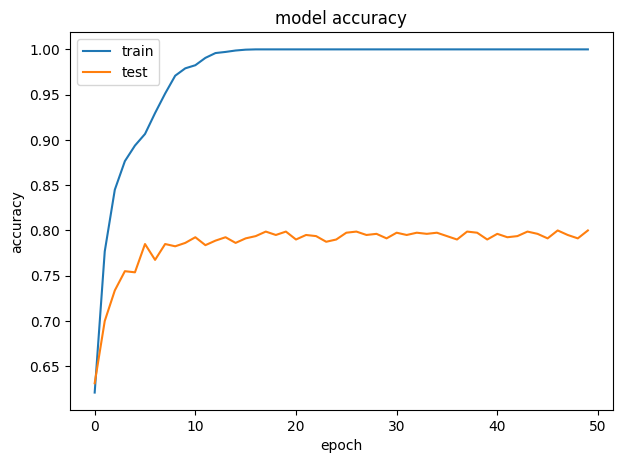

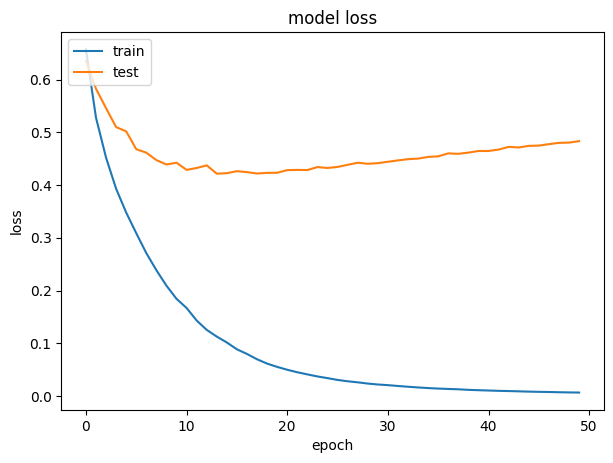

In [39]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### CNN Early Stopping

Epoch 1/30
25/25 [==============================] - 1s 15ms/step - loss: 0.7627 - acc: 0.5134 - val_loss: 0.6450 - val_acc: 0.6137

Epoch 00001: val_loss improved from inf to 0.64498, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5762 - acc: 0.7153 - val_loss: 0.6144 - val_acc: 0.6662

Epoch 00002: val_loss improved from 0.64498 to 0.61443, saving model to best_model.h5
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5071 - acc: 0.7866 - val_loss: 0.6015 - val_acc: 0.6650

Epoch 00003: val_loss improved from 0.61443 to 0.60152, saving model to best_model.h5
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.4487 - acc: 0.8375 - val_loss: 0.5535 - val_acc: 0.7275

Epoch 00004: val_loss improved from 0.60152 to 0.55349, saving model to best_model.h5
Epoch 5/30
25/25 [==============================] - 0s 10ms/step - loss: 0.3956 - acc: 0.8841 - val_loss: 0.5405 - val_acc: 0.7275

Ep

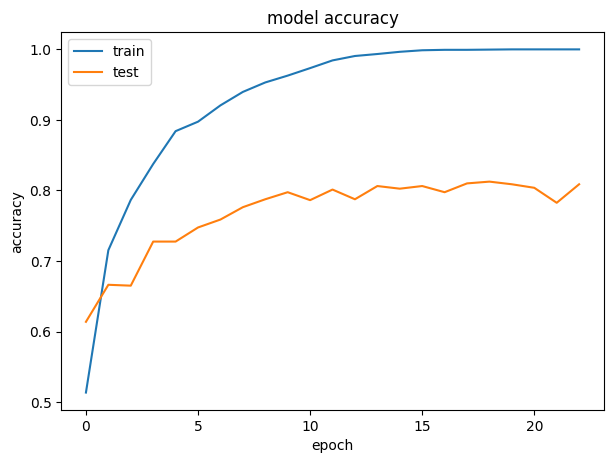

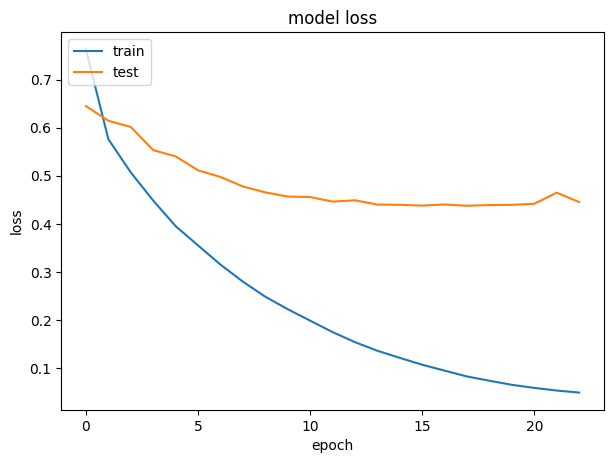

In [40]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### RNN

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 3,546,341
Trainable params: 29,441
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 4s 128ms/step - loss: 0.7223 - acc: 0.5194 - val_loss: 0.6915 - val_acc: 0.5462

Epoch 00001: val_loss improved from inf to 0.69151, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 3s 114ms/step - loss: 0.6881 - acc: 0.5634 - val_loss: 0.6852 - val_acc: 0.5763

Epoch 00002: val

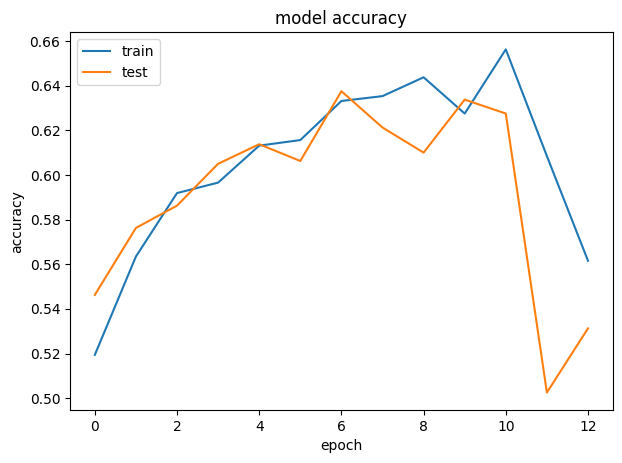

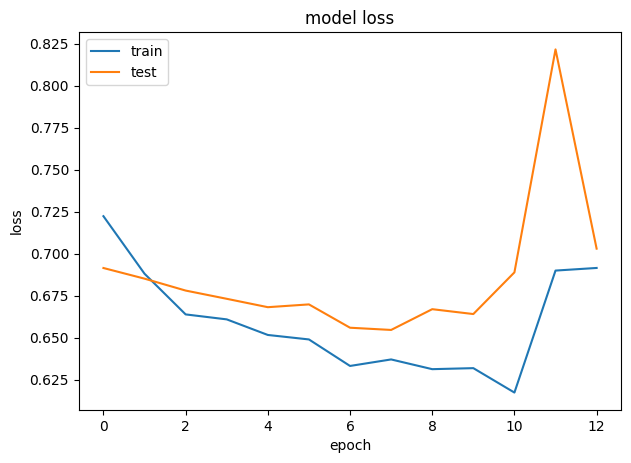

In [41]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### LSTM

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/15
25/25 [==============================] - 9s 259ms/step - loss: 0.6866 - acc: 0.5531 - val_loss: 0.6764 - val_acc: 0.5850
Epoch 2/15
25/25 [==============================] - 6s 241ms/step - loss: 0.6419 - acc: 0.6341 - val_loss: 0.6768 - val_acc: 0.6600
Epoch 3/15
25/25 [==============================] - 6s 240ms/step - loss: 0.6018 - acc: 0.6837 - va

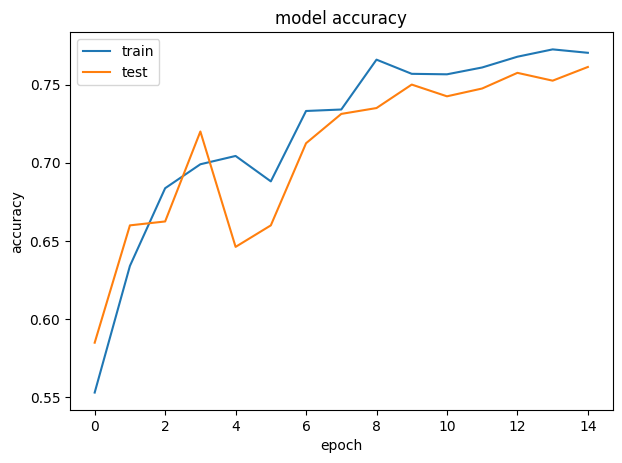

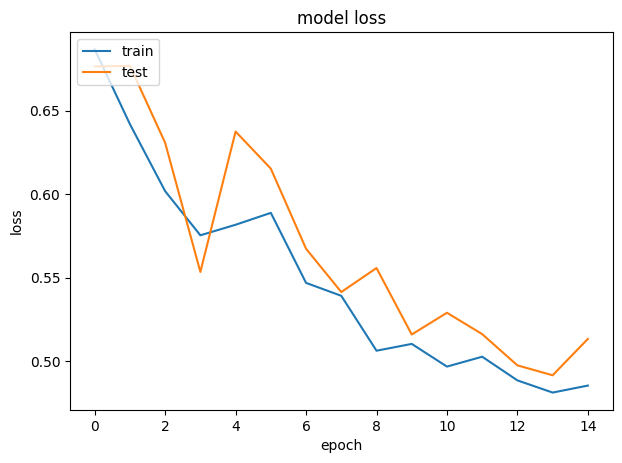

In [42]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### LSTM com Early Stopping

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/100
25/25 [==============================] - 9s 263ms/step - loss: 0.6853 - acc: 0.5506 - val_loss: 0.6790 - val_acc: 0.5775

Epoch 00001: val_loss improved from inf to 0.67901, saving model to best_model.h5
Epoch 2/100
25/25 [==============================] - 6s 242ms/step - loss: 0.6511 - acc: 0.6178 - val_loss: 0.6639 - val_acc: 0.6200

Epoch 00002: 

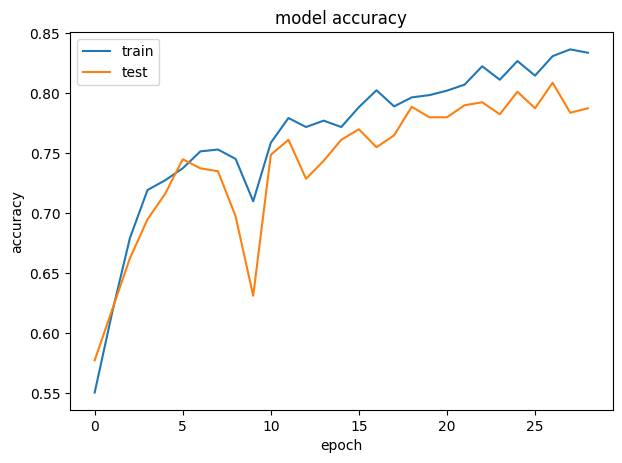

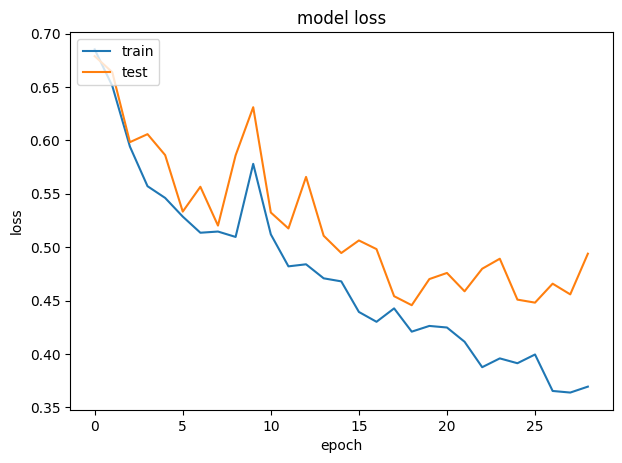

In [43]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, callbacks=[es, mc], validation_split=0.2)

# load a saved model (best model)
model = load_model('best_model.h5')
print(model.summary())

score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Prediction (sample)

In [44]:
instance = sample(X, 1)
print (instance)
instance = tokenizer.texts_to_sequences(instance)

instance = pad_sequences(instance, padding='post', maxlen=maxlen)
print (instance)

score = model.predict(instance)[0][0]
print (score)
if (score >= 0.5):
    print ('Positivo')
else:
    print ('Negativo')

['i had been waiting to see this movie for so long and finally got to yesterday in summary m glad finally did the humor is off the wall hilarious the plot is so unbelievably believable that it has to have at least some truth for it if anything stood out in this movie it is most definitely the coffee shop scene have been there every guy has you get dumped you find out that your ex has fooled around with some guy who you are sure is an asshole now every time you see anything for the next few days you just get horrible thoughts of this placed in all the wrong areas she is screwing everyone and everyone knows it could probably watch that man lick and finger his wallet all day long and look back at myself and laugh for having been there too ']
[[ 204   44  863   14    6   39  231 3454   42    7    8   13    6    5
    85  429    1 4643 1894  117   23   71   37  170  212   41   17   74
    17  162   42    9  128 1138   41 3151  190   12   44  212   30   17
    22  249    5   31  145  170   5

### Prediction (tests)

In [45]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)

        score = model.predict(instance)[0][0]
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'The movie was good, but I hated it',
                  'I hate this movie, it is very bad and terrible']

# score list
score_list(list_instances)

,text,score,rating
0,"The movie was amazing, I loved it, very good",0.977816,Positivo
1,"The movie was good, but I hated it",0.847503,Positivo
2,"I hate this movie, it is very bad and terrible",0.061485,Negativo


Modelo TensorFlow Hub

In [ ]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ('train[:60%]', 'train[60%:]', 'test'), from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_16 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 5s 126ms/step - loss: 0.6694 - accuracy: 0.5249 - val_loss: 0.6196 - val_accuracy: 0.5789
Epoch 2/10
30/30 [==============================] - 4s 118ms/step - loss: 0.5560 - accuracy: 0.6675 - val_loss: 0.5180 - val_accuracy: 0.7253
Epoch 3/10
30/30 [==============================] - 5s 120ms/step - loss: 0.4282 - accu

Modelo Bert

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataset = tf.keras.utils.get_file(fname = 'aclImdb_v1.tar.gz',
                                  origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                                  extract = True)

IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir = IMDB_DATADIR,
                                                                       classes = ['pos', 'neg'],
                                                                       maxlen = 200,
                                                                       train_test_names = ['train', 'test'],
                                                                       preprocess_mode = 'bert')

model = text.text_classifier(name = 'bert',
                             train_data = (x_train, y_train),
                             preproc = preproc)

learner = ktrain.get_learner(model = model,
                             train_data = (x_train, y_train),
                             val_data = (x_test, y_test),
                             batch_size = 6)

learner.fit_onecycle(lr = 2e-5,
                     epochs = 1)

detected encoding: utf-8
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 200
done.


begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 3306s 787ms/step - loss: 0.2959 - accuracy: 0.8736 - val_loss: 0.2191 - val_accuracy: 0.9107
